In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [4]:
# Read our input data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [5]:
# Show statistics about some of our features
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train.drop('vendor_id', axis=1).describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.665,-73.973,40.751,-73.973,40.752,959.492
std,1.314,0.071,0.033,0.071,0.036,5237.432
min,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [6]:
# Find the number of longitude outliers
df_train[df_train['pickup_longitude'] < - 74.2].shape[0]

82

In [7]:
# Find the proportion of vendor_id which is vendor 2
(df_train['vendor_id'] == 2).mean()

0.53495026887986374

In [8]:
# Find the proportion of store_and_fwd_flag tht is positive.
(df_train['store_and_fwd_flag'] == 'Y').mean()

0.0055153964915359748

In [10]:
# Convert pickup_datetime to Timestamp
df_train['pickup_dt'] = pd.to_datetime(df_train['pickup_datetime'])
df_test['pickup_dt'] = pd.to_datetime(df_test['pickup_datetime'])

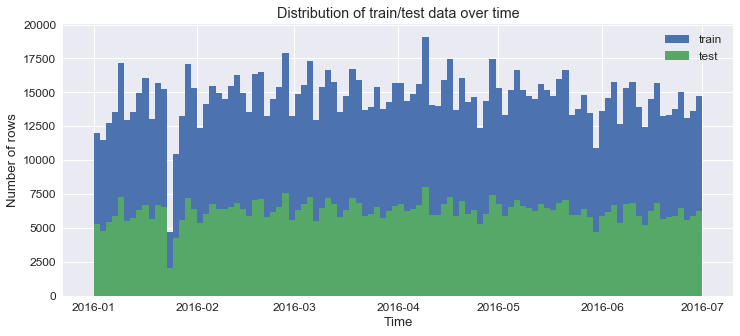

In [11]:
# Plot distribution of the dataset
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
plt.hist([x.to_pydatetime() for x in df_train['pickup_dt']], bins=100, label='train')
plt.hist([x.to_pydatetime() for x in df_test['pickup_dt']], bins=100, label='test')
plt.title('Distribution of train/test data over time')
plt.xlabel('Time')
plt.ylabel('Number of rows')
plt.legend()
plt.show()

In [12]:
# Get the hour of each sample
hours = np.array([t.hour for t in df_train['pickup_dt']])

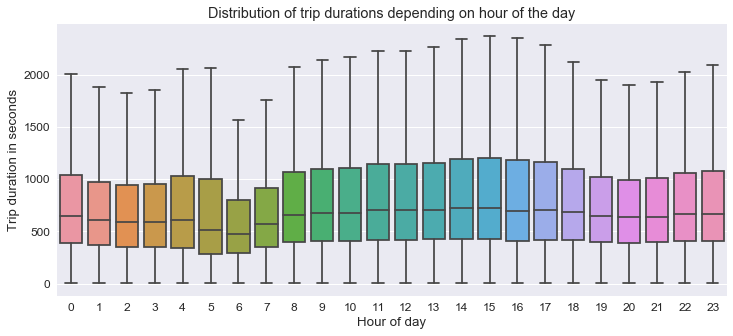

In [13]:
# Plot trip duration distribution based on time of day
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
sns.boxplot(hours, df_train['trip_duration'].values, showfliers=False)
plt.title('Distribution of trip durations depending on hour of the day')
plt.ylabel('Trip duration in seconds')
plt.xlabel('Hour of day')
plt.show()

In [14]:
# Calculate the manhattan distance and speed
manhattan = (np.abs(df_train['pickup_latitude'] - df_train['dropoff_latitude']) + np.abs(df_train['pickup_longitude'] - df_train['dropoff_longitude']))
manhattan_speed = manhattan / df_train['trip_duration']

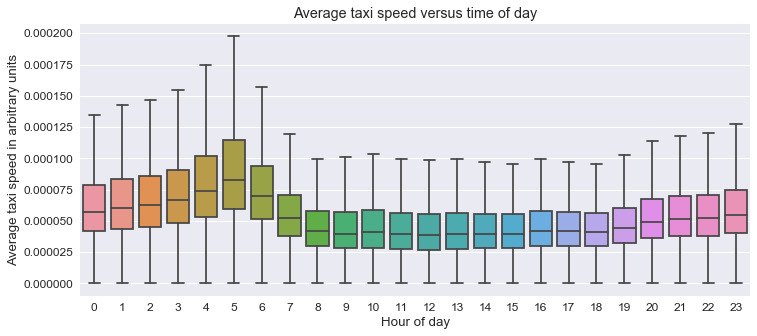

In [15]:
# Plot speed against the time of day
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
sns.boxplot(hours, manhattan_speed, showfliers=False)
plt.title('Average taxi speed versus time of day')
plt.ylabel('Average taxi speed in arbitrary units')
plt.xlabel('Hour of day')
plt.show()

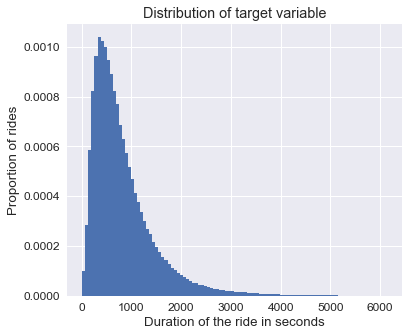

In [32]:
# Plot distribution of the target variable, removing 5K outliers
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.hist(sorted(df_train['trip_duration'])[2500:-2500], bins=100, normed=True)
plt.title('Distribution of target variable')
plt.ylabel('Proportion of rides')
plt.xlabel('Duration of the ride in seconds')
plt.show()

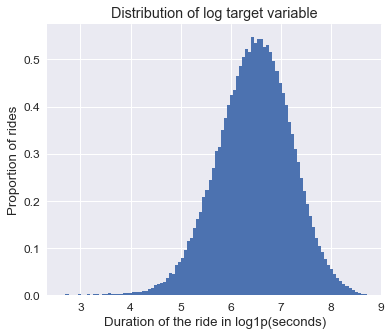

In [33]:
# Plot distribution of the target variable, removing 5K outliers
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.hist(sorted(np.log1p(df_train['trip_duration']))[2500:-2500], bins=100, normed=True)
plt.title('Distribution of log target variable')
plt.ylabel('Proportion of rides')
plt.xlabel('Duration of the ride in log1p(seconds)')
plt.show()

In [17]:
# Calculate the 'predicted' value for the benchmark model
benchmark_val = np.expm1(np.mean(np.log1p(df_train['trip_duration'])))
benchmark_val

642.53628300499236

In [18]:
# Calculate the RMSLE score of the benchmark model
benchmark_score = np.sqrt(np.mean((np.log1p(benchmark_val) - np.log1p(df_train['trip_duration'])) ** 2))
benchmark_score

0.79575923654121561

In [19]:
# Create a submission based on the benchmark model to submit to Kaggle
benchmark_sub = pd.DataFrame({'id': df_test['id'], 'trip_duration': round(benchmark_val, 2)})
benchmark_sub.to_csv('benchmark_submission.csv', index=False)